In [79]:
import argparse
import glob
import math
import ntpath
import os
import shutil
import urllib
import urllib2

from datetime import datetime

import numpy as np
import pandas as pd

from mne import Epochs, pick_types, find_events
from mne.io import concatenate_raws, read_raw_edf

import dhedfreader

In [80]:
# Label values
W = 0
N1 = 1
N2 = 2
N3 = 3
REM = 4
UNKNOWN = 5

stage_dict = {
    "W": W,
    "N1": N1,
    "N2": N2,
    "N3": N3,
    "REM": REM,
    "UNKNOWN": UNKNOWN
}

class_dict = {
    0: "W",
    1: "N1",
    2: "N2",
    3: "N3",
    4: "REM",
    5: "UNKNOWN"
}

ann2label = {
    "Sleep stage W": 0,
    "Sleep stage 1": 1,
    "Sleep stage 2": 2,
    "Sleep stage 3": 3,
    "Sleep stage 4": 3,
    "Sleep stage R": 4,
    "Sleep stage ?": 5,
    "Movement time": 5
}

EPOCH_SEC_SIZE = 30

In [56]:
first = pd.DataFrame()
raw = read_raw_edf('data/SC4001E0-PSG.edf')
sampling_rate = raw.info['sfreq']


raw_eeg_fpz = raw.to_data_frame(scaling_time=100.0)['EEG Fpz-Cz']
raw_eeg_fpz = raw_eeg_fpz.to_frame()
raw_eeg_fpz.set_index(np.arange
                      (len(raw_eeg_fpz)))

raw_eeg_pz = raw.to_data_frame(scaling_time=100.0)['EEG Pz-Oz']
raw_eeg_pz = raw_eeg_pz.to_frame()
raw_eeg_pz.set_index(np.arange(len(raw_eeg_pz)))

raw_eog = raw.to_data_frame(scaling_time=100.0)['EOG horizontal']
raw_eog = raw_eog.to_frame()
raw_eog.set_index(np.arange(len(raw_eog)))

raw_emg = raw.to_data_frame(scaling_time=100.0)['EMG submental']
raw_emg = raw_emg.to_frame()
raw_emg.set_index(np.arange(len(raw_emg)))

event_marker = raw.to_data_frame(scaling_time=100.0)['Event marker']
event_marker = event_marker.to_frame()
event_marker.set_index(np.arange(len(event_marker)))

first['EEG Fpz-Cz'] = raw_eeg_fpz
first['EEG Pz-Oz'] = raw_eeg_pz
first['EOG horizontal'] = raw_eog
first['EMG submental'] = raw_emg
first['Event Marker'] = event_marker
first.head(10)

Extracting edf Parameters from data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Ready.
Converting time column to int64...
Converting time column to int64...
Converting time column to int64...
Converting time column to int64...
Converting time column to int64...


,EEG Fpz-Cz,EEG Pz-Oz,EOG horizontal,EMG submental,Event Marker
0,5.016850,-2.467399,16.508669,3.552,920000000.0
1,-2.578755,1.467399,16.015873,3.552,919000000.0
2,1.359707,-4.098901,9.609524,3.554,918000000.0
3,-2.391209,-2.659341,1.724786,3.556,917000000.0
4,-5.204396,-0.739927,7.638339,3.558,917000000.0
5,-7.454945,-1.411722,2.710379,3.558,916000000.0
6,-8.298901,-0.931868,0.246398,3.560,915000000.0
7,-6.892308,1.851282,-0.739194,3.562,914000000.0
8,-3.704029,-0.835897,1.231990,3.562,914000000.0
9,-0.984615,-0.835897,5.174359,3.564,913000000.0


Text(0,0.5,u'EEG Fpz-Cz data')

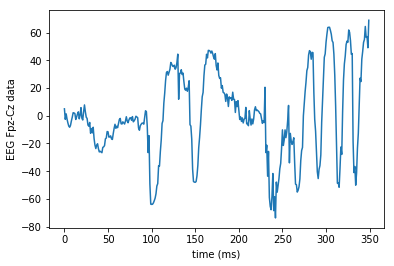

In [21]:
import matplotlib.pyplot as plt
import plotly.plotly as py

epoch_size = 350
time = list(xrange(epoch_size))
plt.plot(time, first['EEG Fpz-Cz'].head(350))
plt.xlabel('time (ms)')
plt.ylabel('EEG Fpz-Cz data')

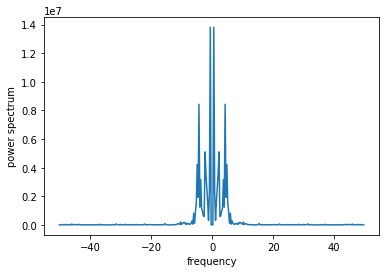

In [107]:
from __future__ import division

data = first['EEG Fpz-Cz'].head(350)
ps = np.abs(np.fft.fft(data))**2

time_step = 1 / 100
freqs = np.fft.fftfreq(data.size, time_step)
idx = np.argsort(freqs)
plt.xlabel("frequency")
plt.ylabel("power spectrum")
plt.plot(freqs[idx], ps[idx])

In [102]:
max(freqs)

49.71428571428571

## perform Energy Calculation in Frequency Domain 
### using Parsevals theorem:
![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/bd01ef048644b8295d7e2332488c2013ec04b742)


In [112]:
vals = first['EEG Fpz-Cz'].head(350).values
FFT = np.fft.fft(vals)
freq_energy = np.sum(np.abs(FFT)**2)/data.size

print 'Energy in Frequency Domain = %f'%freq_energy

Energy in Frequency Domain = 336442.416185


Text(0,0.5,u'Mean band Amplitude')

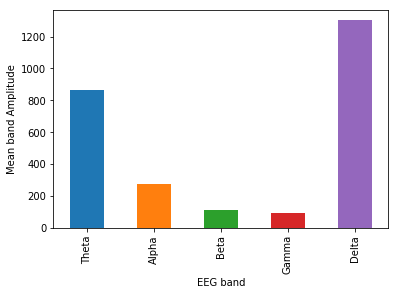

In [83]:
fs = 100                                # Sampling rate (100 Hz)
data = first['EEG Fpz-Cz'].head(350)    # 3.5 sec of data b/w 0.0-100.0

# Get real amplitudes of FFT (only in postive frequencies)
fft_vals = np.absolute(np.fft.rfft(data))

# Get frequencies for amplitudes in Hz
fft_freq = np.fft.rfftfreq(len(data), 1.0/fs)

# Define EEG bands
eeg_bands = {'Delta': (0, 4),
             'Theta': (4, 8),
             'Alpha': (8, 12),
             'Beta': (12, 30),
             'Gamma': (30, 45)}

# Take the mean of the fft amplitude for each EEG band
eeg_band_fft = dict()
for band in eeg_bands:  
    freq_ix = np.where((fft_freq >= eeg_bands[band][0]) & 
                       (fft_freq <= eeg_bands[band][1]))[0]
    eeg_band_fft[band] = np.mean(fft_vals[freq_ix])

# Plot the data 
df = pd.DataFrame(columns=['band', 'val'])
df['band'] = eeg_bands.keys()
df['val'] = [eeg_band_fft[band] for band in eeg_bands]
ax = df.plot.bar(x='band', y='val', legend=False)
ax.set_xlabel("EEG band")
ax.set_ylabel("Mean band Amplitude")

In [106]:
# import matplotlib.pyplot as plt
# import plotly.plotly as py

# epoch_size = len(first['EMG submental'])
# time = list(xrange(epoch_size))
# plt.plot(time, first['EMG submental'])
# plt.xlabel('time (ms)')
# plt.ylabel('EMG data')

In [68]:
events = mne.find_events(raw, stim_channel='EEG Fpz-Cz')
# picks MEG gradiometers
picks = mne.pick_types(raw.info,eeg=True, eog=True, stim=False)

# Construct Epochs
tmin, tmax = -1., 3.
baseline = (None, 0)



# define frequencies of interest (log-spaced)
freqs = np.logspace(*np.log10([6, 35]), num=8)
n_cycles = freqs / 2.  # different number of cycle per frequency

power, itc = tfr_morlet(epoch=0, freqs=freqs, n_cycles=n_cycles, use_fft=True,
                        return_itc=True, decim=3, n_jobs=1)

fig, axis = plt.subplots(1, 2, figsize=(7, 4))
power.plot_topomap(ch_type='grad', tmin=0.5, tmax=1.5, fmin=8, fmax=12,
                   baseline=(-0.5, 0), mode='logratio', axes=axis[0],
                   title='Alpha', vmax=0.45, show=False)
power.plot_topomap(ch_type='grad', tmin=0.5, tmax=1.5, fmin=13, fmax=25,
                   baseline=(-0.5, 0), mode='logratio', axes=axis[1],
                   title='Beta', vmax=0.45, show=False)
mne.viz.tight_layout()
plt.show()

TypeError: tfr_morlet() got an unexpected keyword argument 'epoch'

In [54]:
raw.ch_names

[u'EEG Fpz-Cz',
 u'EEG Pz-Oz',
 u'EOG horizontal',
 u'Resp oro-nasal',
 u'EMG submental',
 u'Temp rectal',
 u'Event marker']

In [69]:
# Read annotation and its header
f = open(ann_fnames[i], 'r')
reader_ann = dhedfreader.BaseEDFReader(f)
reader_ann.read_header()
h_ann = reader_ann.header

NameError: name 'ann_fnames' is not defined